In [1]:
#!pip install spacy
#!pip install jupyterthemes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from spacy.matcher import PhraseMatcher


In [2]:
#!pip install wordcloud
!pip install rapidfuzz
from wordcloud import WordCloud
import re
from fuzzywuzzy import process
def clean_entity(entity):
    return re.sub(r'[^A-Za-z0-9 ]+', '', entity)

In [3]:
import spacy

def download_spacy_model(model_name):
    try:
        spacy.cli.download(model_name)
    except Exception as e:
        print(f"An error occurred while downloading the model {model_name}: {e}")

download_spacy_model("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
nlp = spacy.load('en_core_web_md')


In [5]:
excel_file_path = r"C:\Users\achra\Downloads\Workbook.xlsx"
dfs_dict = pd.read_excel(excel_file_path, sheet_name=None)
orders = dfs_dict['Half Year Orders']
cafe_reviews = dfs_dict['Primary Cafe Reviews']
competitor_reviews = dfs_dict['Comp-A Cafe Review']
orders.head()

,item id,name,order id,order time (utc),quantity,total price,total Price in dollars
0,bda74f81-57b3-45f1-a849-d9c28aeae578,Latte,ba1b3725-8135-492d-86ec-8bcbb8d5a030,2023-09-29T16:26:06Z,2,900,9.0
1,a3ad5245-9713-413a-b0e2-a30a4b7a08ff,Spicy Turkey,ba1b3725-8135-492d-86ec-8bcbb8d5a030,2023-09-29T16:26:06Z,1,1300,13.0
2,f3f72673-09b4-4ac1-951b-1ac6ed1a0d79,Matcha Latte,4dba82c1-ba62-434f-9659-b6171769ed8b,2023-09-29T16:24:57Z,1,600,6.0
3,e366193e-b6fa-4dcd-a570-bef843003c96,Roasted Veggie Salad,9cd8b191-208a-4bd3-bae7-492f9dab8ce5,2023-09-29T16:23:43Z,1,1450,14.5
4,ddf5a1ad-e817-4eac-918c-62622da575b2,Grilled Cheese,9cd8b191-208a-4bd3-bae7-492f9dab8ce5,2023-09-29T16:23:43Z,1,1050,10.5


In [6]:
def process_review(review):
    doc = nlp(review)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

cafe_reviews['entities'] = cafe_reviews['Review Comment'].apply(process_review)
competitor_reviews['entities'] = competitor_reviews['Review Comment'].apply(process_review)

In [7]:
cafe_reviews.head()

,Review Score,Review Comment,entities
0,5,A little cafe on a side street in NYC close to...,"[(NYC, LOC), (the year, DATE)]"
1,3,The food: 3/5 I came here because someone on Y...,"[(3/5, CARDINAL), (Yelp, ORG), (Dunkin, PERSON..."
2,3,Sip and Co is a cute shop where you can fulfil...,"[(Sip and Co, ORG), (two seconds, TIME)]"
3,5,"We wanted a quick breakfast, close to our Hote...","[(Hotel, ORG), (about 10, CARDINAL), (Fall, EV..."
4,5,Sip and Co was a great stop for a light breakf...,"[(Sip and Co, ORG), (five minutes, TIME)]"


In [8]:
competitor_reviews.head()

,Review Score,Review Comment,entities
0,5,Just perfect. Went each of the three mornings ...,"[(NYC, GPE), (each day, DATE)]"
1,4,I like this place! It makes me feel like at ho...,"[(apricot, ORG)]"
2,4,Wow! What a cute French coffee shop. The place...,"[(French, NORP), (Central Park, LOC)]"
3,5,"I've had cappuccinos all over the world, and Z...","[(Zibetto, PERSON)]"
4,5,Love this little pocket of authentic Italian c...,"[(Italian, NORP), (Central Park, LOC), (15, CA..."


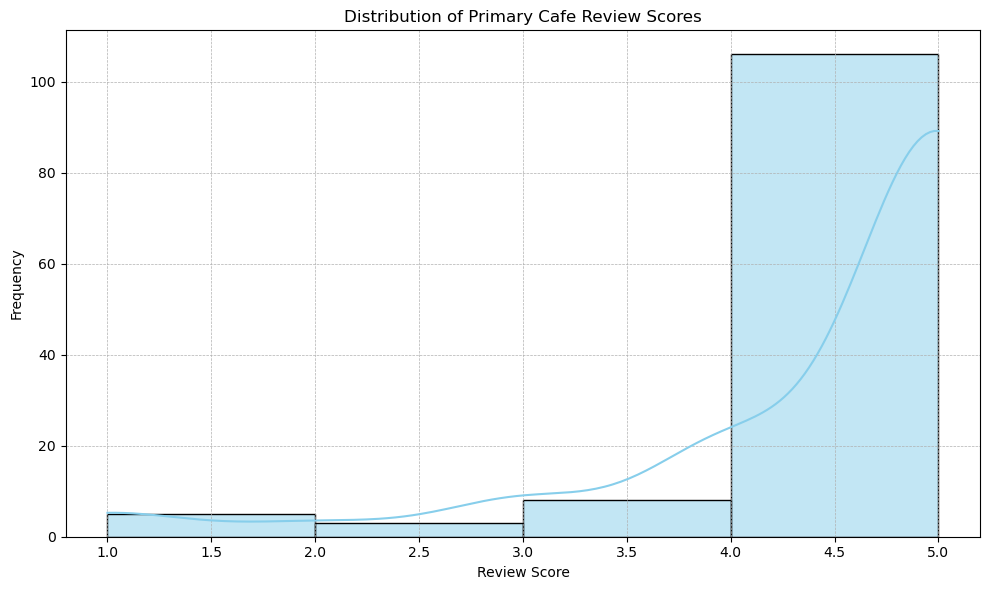

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(cafe_reviews['Review Score'], kde=True, color='skyblue', binwidth=1)
plt.title('Distribution of Primary Cafe Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

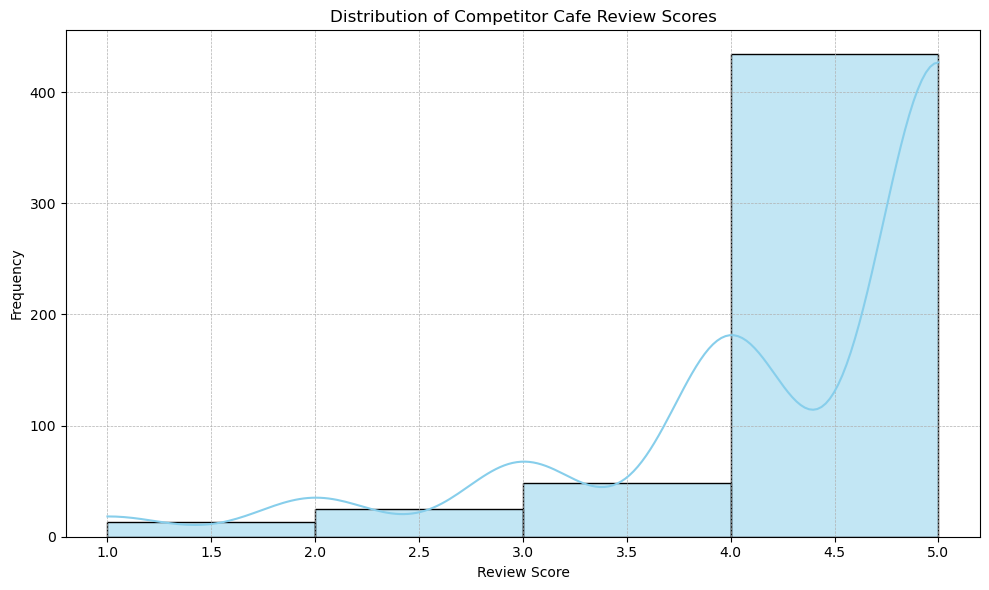

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(competitor_reviews['Review Score'], kde=True, color='skyblue', binwidth=1)
plt.title('Distribution of Competitor Cafe Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

In [11]:
print('Primary Cafe Review Avg Score: ' + str(cafe_reviews['Review Score'].mean()), 'Competitor Cafe Review Avg Score: ' + str(competitor_reviews['Review Score'].mean()))

Primary Cafe Review Avg Score: 4.467213114754099 Competitor Cafe Review Avg Score: 4.323076923076923


In [12]:
cafe_entities = [entity for sublist in cafe_reviews['entities'] for entity, label in sublist]
competitor_entities = [entity for sublist in competitor_reviews['entities'] for entity, label in sublist]
cafe_entity_freq = Counter(cafe_entities)
competitor_entity_freq = Counter(competitor_entities)
cafe_freq_df = pd.DataFrame(cafe_entity_freq.items(), columns=['Entity', 'Cafe Frequency'])
competitor_freq_df = pd.DataFrame(competitor_entity_freq.items(), columns=['Entity', 'Competitor Frequency'])
merged_freq_df = cafe_freq_df.merge(competitor_freq_df, on='Entity', how='outer').fillna(0)

In [13]:
N = 20
merged_freq_df = merged_freq_df.reset_index(drop=True)
heatmap_data = merged_freq_df.melt(id_vars=['Entity'], var_name='Source', value_name='Frequency')
heatmap_data_pivot = heatmap_data.pivot(index='Entity', columns='Source', values='Frequency')
heatmap_data_pivot = heatmap_data_pivot.fillna(0)
top_entities = heatmap_data_pivot.sum(axis=1).nlargest(N).index
heatmap_data_pivot = heatmap_data_pivot.loc[top_entities]

cafe_reviews.columns

Index(['Review Score', 'Review Comment', 'entities'], dtype='object')

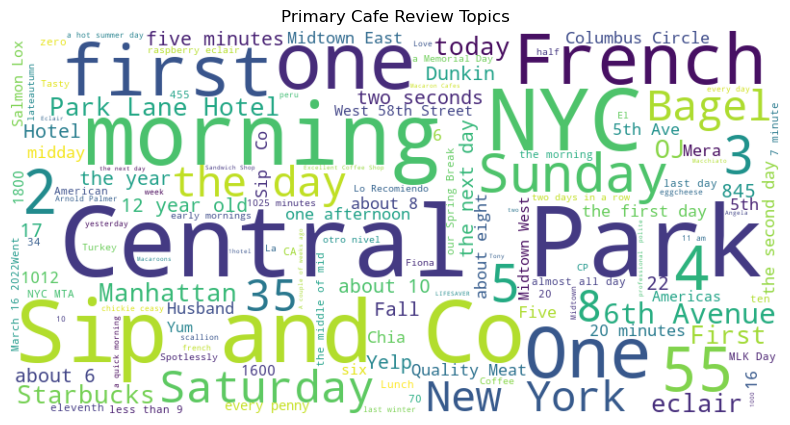

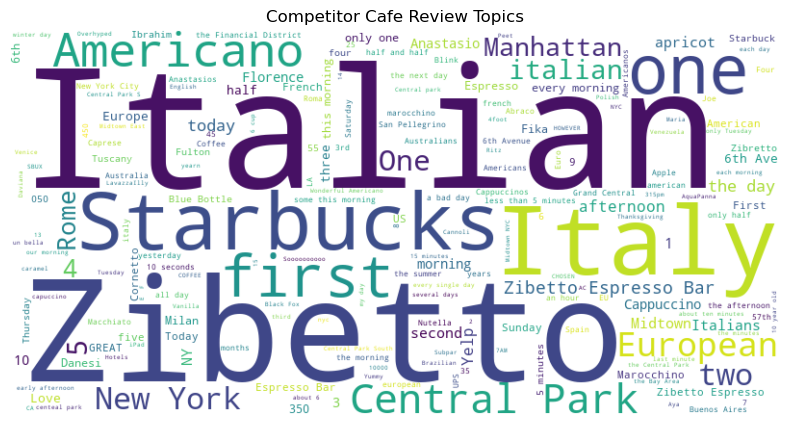

In [14]:
def create_word_cloud(frequencies, title):
    frequencies_dict = dict(frequencies)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')  
    plt.show()
    
cafe_entity_freq_clean = Counter({clean_entity(entity): count for entity, count in cafe_entity_freq.items()})
competitor_entity_freq_clean = Counter({clean_entity(entity): count for entity, count in competitor_entity_freq.items()})

create_word_cloud(cafe_entity_freq_clean, 'Primary Cafe Review Topics')
create_word_cloud(competitor_entity_freq_clean, 'Competitor Cafe Review Topics')

In [15]:
menu_items = orders['name'].unique()
from rapidfuzz import process, fuzz
def get_fuzzy_phrase_frequencies(reviews, menu_items, similarity_threshold=75):
    phrase_counter = Counter()
    for review in reviews:
        review_lower = re.sub(r'[^\w\s]', '', review.lower()).split()
        ngrams = [' '.join(review_lower[i:i+n]) for n in range(1, 4) for i in range(len(review_lower)-n+1)]
        
        for ngram in ngrams:
            if ngram == 'large' or ngram == 'large ' or ngram == 'Large ':
                continue
            potential_matches = process.extract(ngram, menu_items, scorer=fuzz.token_sort_ratio, score_cutoff=similarity_threshold, limit=None)
            for match, similarity, _ in potential_matches:
                if match.lower() == 'large':
                    continue
                phrase_counter[match] += 1
                
    return phrase_counter


primary_phrase_freq = get_fuzzy_phrase_frequencies(cafe_reviews['Review Comment'], menu_items)
competitor_phrase_freq = get_fuzzy_phrase_frequencies(competitor_reviews['Review Comment'], menu_items)

primary_phrase_freq



Counter({'Latte': 38,
         'Toast': 37,
         'Bacon side': 2,
         'Avocado Toast': 31,
         'Sausage on side': 1,
         'Large ': 32,
         'Bagel': 40,
         'Scone': 24,
         'Honey': 27,
         'Eclairs ': 21,
         'Lemonade': 5,
         'Donut ': 18,
         'Donut': 18,
         '5 ice ': 1,
         'Chicken Club': 2,
         'Tea bag': 1,
         'Grilled Chicken Club': 2,
         'Iced': 15,
         'Van ': 26,
         'Matcha Latte': 9,
         'Vanilla': 10,
         'Chai Latte': 3,
         'Caesar Wrap': 2,
         'Jam': 7,
         'Ham': 7,
         'Jam ': 7,
         'Muffin': 4,
         'Raspberry Bar': 6,
         'Cinnamon Bun': 1,
         'Chocolate': 12,
         'Ice chocolate': 16,
         'Croissant': 10,
         'Choc. Croissant': 4,
         'Espresso': 12,
         'Espresso ': 12,
         'Cold Brew': 2,
         'Eclair': 18,
         'Salmon': 14,
         'Milk ': 14,
         'Milk': 14,
         'Corta

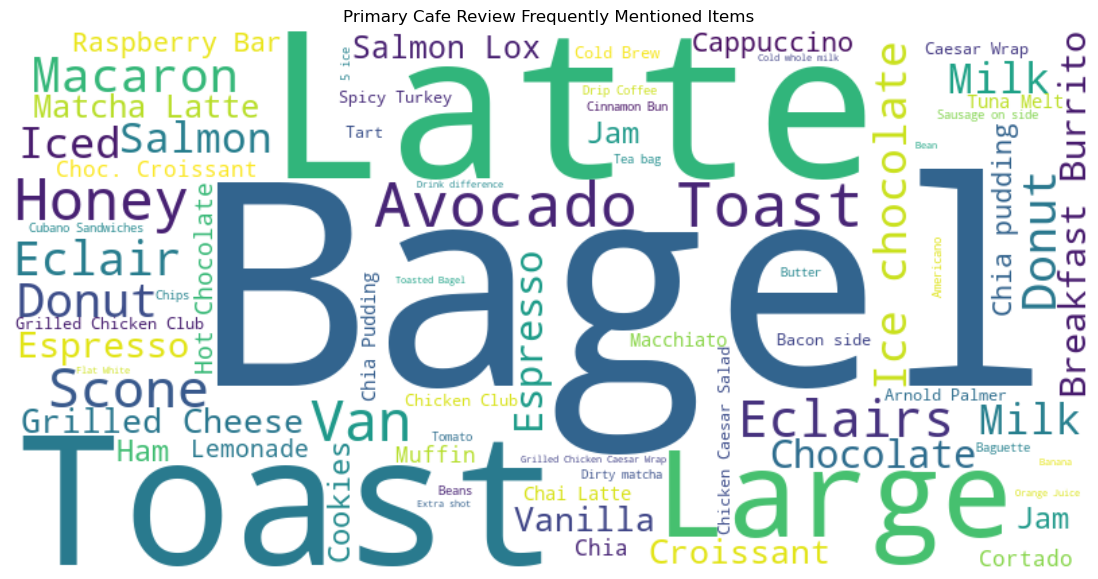

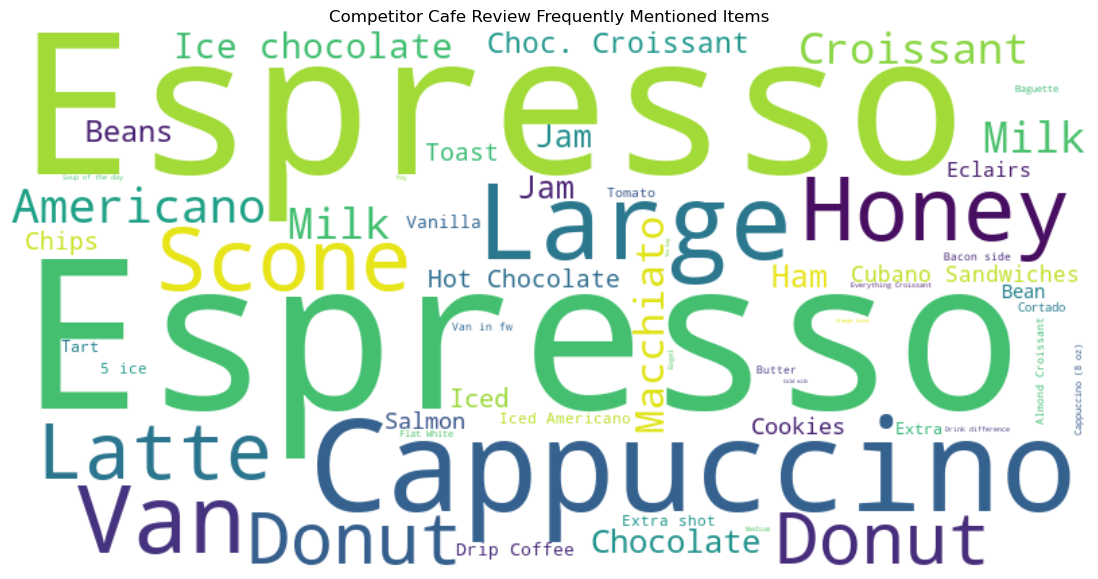

In [16]:

def create_phrase_cloud(frequencies, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
create_phrase_cloud(primary_phrase_freq, 'Primary Cafe Review Frequently Mentioned Items')
create_phrase_cloud(competitor_phrase_freq, 'Competitor Cafe Review Frequently Mentioned Items')

In [17]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
spacy_text_blob = SpacyTextBlob(nlp)


nlp.add_pipe('spacytextblob')

In [18]:
from spacytextblob.spacytextblob import SpacyTextBlob
def analyze_sentiment(review):
    doc = nlp(review)
    return doc._.polarity

cafe_reviews['Sentiment'] = cafe_reviews['Review Comment'].apply(analyze_sentiment)
competitor_reviews['Sentiment'] = competitor_reviews['Review Comment'].apply(analyze_sentiment)


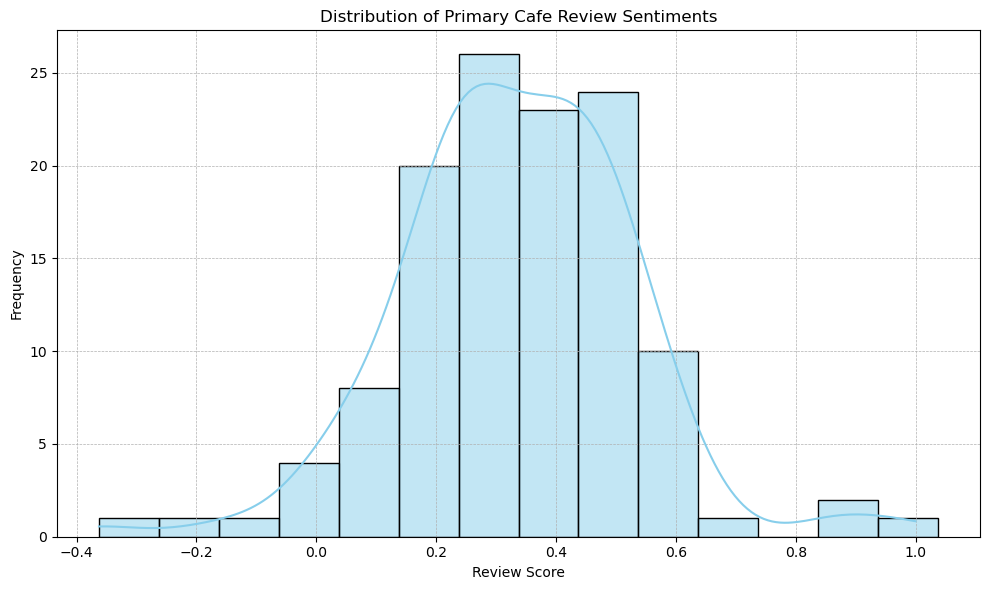

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(cafe_reviews['Sentiment'], kde=True, color='skyblue', binwidth=0.10)
plt.title('Distribution of Primary Cafe Review Sentiments')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

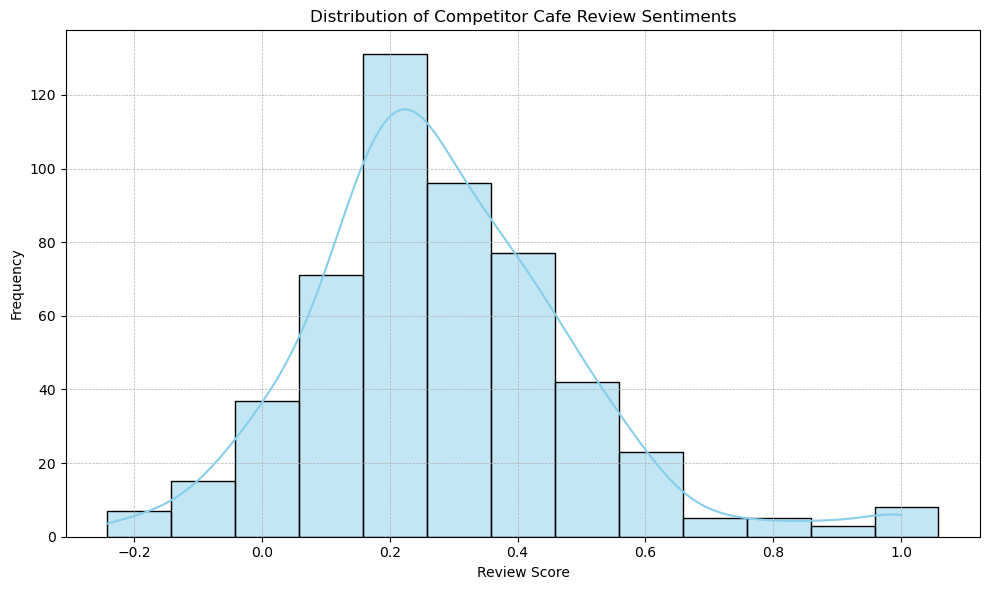

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(competitor_reviews['Sentiment'], kde=True, color='skyblue', binwidth=0.10)
plt.title('Distribution of Competitor Cafe Review Sentiments')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

In [21]:
cafe_reviews.head()

,Review Score,Review Comment,entities,Sentiment
0,5,A little cafe on a side street in NYC close to...,"[(NYC, LOC), (the year, DATE)]",0.251816
1,3,The food: 3/5 I came here because someone on Y...,"[(3/5, CARDINAL), (Yelp, ORG), (Dunkin, PERSON...",0.227083
2,3,Sip and Co is a cute shop where you can fulfil...,"[(Sip and Co, ORG), (two seconds, TIME)]",0.152051
3,5,"We wanted a quick breakfast, close to our Hote...","[(Hotel, ORG), (about 10, CARDINAL), (Fall, EV...",0.367014
4,5,Sip and Co was a great stop for a light breakf...,"[(Sip and Co, ORG), (five minutes, TIME)]",0.306228


In [22]:
from collections import defaultdict
from rapidfuzz import process, fuzz

def calculate_average_sentiment(reviews, menu_items, similarity_threshold=75):
    sentiment_totals = defaultdict(float)
    mention_counts = defaultdict(int)
    
    for review, sentiment in zip(reviews['Review Comment'], reviews['Sentiment']):
        review_lower = re.sub(r'[^\w\s]', '', review.lower())
        ngrams = [' '.join(review_lower.split()[i:i+n]) for n in range(1, 4) for i in range(len(review_lower.split())-n+1)]
        
        for ngram in ngrams:
            if ngram.lower() == 'large':
                continue
            potential_matches = process.extract(ngram, menu_items, scorer=fuzz.token_sort_ratio, score_cutoff=similarity_threshold, limit=None)
            for match, similarity, _ in potential_matches:
                if match.lower() == 'large':
                    continue
                sentiment_totals[match] += sentiment
                mention_counts[match] += 1


    average_sentiments = {item: sentiment_totals[item] / mention_counts[item] for item in sentiment_totals if mention_counts[item] > 0}

    return average_sentiments


primary_sentiments = calculate_average_sentiment(cafe_reviews, menu_items)
competitor_sentiments = calculate_average_sentiment(competitor_reviews, menu_items)


sentiment_comparison_df = pd.DataFrame({
    'Menu Item': menu_items,
    'Primary Cafe Avg Sentiment': [primary_sentiments.get(item, 0) for item in menu_items],
    'Competitor Cafe Avg Sentiment': [competitor_sentiments.get(item, 0) for item in menu_items]
})

sentiment_comparison_df['Abs Difference in Sentiment'] = abs(sentiment_comparison_df['Primary Cafe Avg Sentiment'] - sentiment_comparison_df['Competitor Cafe Avg Sentiment'])

sentiment_comparison_df = sentiment_comparison_df.sort_values(by='Abs Difference in Sentiment', ascending=False)

sentiment_comparison_df.head(20)

,Menu Item,Primary Cafe Avg Sentiment,Competitor Cafe Avg Sentiment,Abs Difference in Sentiment
79,Cubano Sandwiches,0.900000,0.216399,0.683601
6,Banana,0.517708,0.000000,0.517708
69,Tuna Melt,0.488954,0.000000,0.488954
48,Everything Croissant,0.000000,0.454722,0.454722
56,Cortado,0.484439,0.035509,0.448930
43,Cinnamon Bun,0.413889,0.000000,0.413889
160,Baguette,0.028571,0.430781,0.402210
27,Almond Croissant,0.000000,0.399261,0.399261
25,Breakfast Burrito,0.395020,0.000000,0.395020
107,Grilled Chicken Caesar Wrap,0.390000,0.000000,0.390000


In [23]:
filtered_df = sentiment_comparison_df[(sentiment_comparison_df['Primary Cafe Avg Sentiment'] != 0) & (sentiment_comparison_df['Competitor Cafe Avg Sentiment'] != 0)]

filtered_df.sort_values(by = 'Abs Difference in Sentiment', ascending = False)

filtered_df.head(30)



,Menu Item,Primary Cafe Avg Sentiment,Competitor Cafe Avg Sentiment,Abs Difference in Sentiment
79,Cubano Sandwiches,0.900000,0.216399,0.683601
56,Cortado,0.484439,0.035509,0.448930
160,Baguette,0.028571,0.430781,0.402210
34,Orange Juice,0.575000,0.188409,0.386591
165,Tea bag,0.152051,0.487500,0.335449
5,Chips,0.459848,0.190430,0.269419
111,Drink difference,0.392208,0.133185,0.259023
109,Extra shot,0.263542,0.051292,0.212250
12,Hot Chocolate,0.422004,0.211513,0.210491
9,Bagel,0.271356,0.086394,0.184962


In [24]:
filtered_df_primary_cafe = sentiment_comparison_df[(sentiment_comparison_df['Primary Cafe Avg Sentiment'] != 0) ]
filtered_df_primary_cafe = filtered_df_primary_cafe.sort_values(by = 'Primary Cafe Avg Sentiment', ascending = True)
filtered_df_primary_cafe.head(20)

,Menu Item,Primary Cafe Avg Sentiment,Competitor Cafe Avg Sentiment,Abs Difference in Sentiment
160,Baguette,0.028571,0.430781,0.402210
13,Chicken Club,0.090311,0.000000,0.090311
88,Grilled Chicken Club,0.090311,0.000000,0.090311
116,Tart,0.112102,0.289004,0.176902
99,Tomato,0.138697,0.254951,0.116254
165,Tea bag,0.152051,0.487500,0.335449
120,5 ice,0.152051,0.160414,0.008363
7,Cold Brew,0.190799,0.000000,0.190799
118,Cold whole milk,0.214583,0.000000,0.214583
73,Caesar Wrap,0.215667,0.000000,0.215667


In [29]:
!pip install --upgrade transformers
from transformers import pipeline
aspects_to_analyze = {
    'customer service': [
        'service', 'staff', 'barista', 'manager', 'attitude', 'friendliness', 'efficiency', 'helpfulness'
    ],
    'wait time': [
        'wait', 'waiting', 'line', 'queue', 'delay', 'time', 'long', 'short', 'minutes', 'quick', 'slow'
    ],
    'price': [
        'price', 'cost', 'expensive', 'cheap', 'value', 'affordable', 'overpriced', 'pricy', 'deal', 'worth'
    ],
    'ambiance and decor': [
        'ambiance', 'ambience', 'decor', 'atmosphere', 'vibe', 'mood', 'design', 'interior', 'lighting', 'music', 'theme', 'cozy', 'comfortable', 'stylish', 'elegant', 'chic'
    ],
    'seating and space': [
        'seating', 'space', 'table', 'chair', 'booth', 'comfort', 'roomy', 'cramped', 'crowded', 'layout', 'arrangement', 'cozy', 'spacious', 'outdoor', 'patio', 'inside', 'interior'
    ]
}
sentiment_pipeline = pipeline("sentiment-analysis")
def get_bert_sentiment(sentence):
    result = sentiment_pipeline(sentence)[0]
    label = result['label']
    score = result['score']
    return label, score
def aspect_based_sentiment_analysis(sentence, aspects, threshold=95):
    aspect_sentiments = {aspect: [] for aspect in aspects}
    sentence_text = sentence.lower()
    print(f"Analyzing sentence: '{sentence}'")
    for aspect, keywords in aspects.items():
        for keyword in keywords:
            match = process.extractOne(sentence_text, [keyword] + keywords, scorer=fuzz.partial_ratio)
            if match and match[1] >= threshold:
                label, score = get_bert_sentiment(sentence_text)
                aspect_sentiments[aspect].append((label, score))
                print(f"  - Matched '{match[0]}' for aspect '{aspect}'. Sentiment: {label}, Score: {score}")
                break  # Break after the first match for an aspect to prevent multiple matches
    return aspect_sentiments
def summarize_aspect_sentiments(reviews_df, aspects):
    summarized_sentiments = {aspect: {'mentions': 0, 'positive': 0, 'negative': 0, 'neutral': 0} for aspect in aspects}
    for review in reviews_df['Review Comment']:
        doc = nlp(review)
        for sentence in doc.sents:
            sentiments = aspect_based_sentiment_analysis(sentence.text, aspects)
            for aspect, sentiment_details in sentiments.items():
                for detail in sentiment_details:
                    label, score = detail
                    summarized_sentiments[aspect]['mentions'] += 1
                    if label == 'POSITIVE' and score > 0.2:
                        summarized_sentiments[aspect]['positive'] += 1
                    elif label == 'NEGATIVE' and score > 0.2:  # Assuming you want to use the score for something
                        summarized_sentiments[aspect]['negative'] += 1
                    else:
                        summarized_sentiments[aspect]['neutral'] += 1
    return summarized_sentiments

summarized_aspect_sentiments = summarize_aspect_sentiments(cafe_reviews, aspects_to_analyze)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Analyzing sentence: 'A little cafe on a side street in NYC close to the park, this is the perfect spot for a quick casual bite.'
  - Matched 'quick' for aspect 'wait time'. Sentiment: POSITIVE, Score: 0.9994219541549683
Analyzing sentence: 'Pumpkin spice latte is a bonus this time of the year --
Avocado toast loaded with arugula and tomatoes on a delicious thick rustic bread.'
  - Matched 'time' for aspect 'wait time'. Sentiment: POSITIVE, Score: 0.999114453792572
Analyzing sentence: 'What else do you need?'
Analyzing sentence: 'Well ....there were some beautiful pastries in the case we passed on -- but that was a tough decision.
'
Analyzing sentence: 'Spots outside as well as a few inside for seating.'
  - Matched 'seating' for aspect 'seating and space'. Sentiment: NEGATIVE, Score: 0.6287627220153809
Analyzing sentence: 'Service was super quick-'
  - Matched 'service' for aspect 'customer service'. Sentiment: NEGATIVE, Score: 0.6734476089477539
  - Matched 'quick' for aspect 'wait ti

  - Matched 'service' for aspect 'customer service'. Sentiment: POSITIVE, Score: 0.9986384510993958
  - Matched 'long' for aspect 'wait time'. Sentiment: POSITIVE, Score: 0.9986384510993958
  - Matched 'seating' for aspect 'seating and space'. Sentiment: POSITIVE, Score: 0.9986384510993958
Analyzing sentence: 'My pumpkin spice latte perfect.'
Analyzing sentence: 'Not overly sweet which I appreciated.'
Analyzing sentence: 'The spices...'
Analyzing sentence: 'yum!  '
Analyzing sentence: 'Fall is in the air!  '
Analyzing sentence: 'Bagel and cream cheese good but the avocado toast tip top.'
Analyzing sentence: 'Lots of arugula, and tomatoes atop a thick hearty wheat bread with of course perfectly flavored avocado!'
Analyzing sentence: 'Sip and Co was a great stop for a light breakfast with friends.'
Analyzing sentence: 'I ordered the iced matcha latte and an everything bagel with a scrambled egg and bacon.'
Analyzing sentence: 'The bagel was surprisingly affordable for a small coffee shop

Analyzing sentence: 'Cute spot in Midtown East with decently priced and tasty selections!'
  - Matched 'price' for aspect 'price'. Sentiment: POSITIVE, Score: 0.9998806715011597
Analyzing sentence: 'I got a matcha latte with oat milk which tasted good, but pretty standard-- not especially amazing.'
Analyzing sentence: 'The matcha cookie was also pretty good-- not too sweet and had a nice crunch to it.'
Analyzing sentence: 'I was able to get a very good tasting espresso macchiato here.'
Analyzing sentence: 'Unfortunately they only offer sweetened milk alternatives.'
Analyzing sentence: 'Five star for the espresso macchiato losing one*do the fact that I couldn't get unsweetened almond milk.'
Analyzing sentence: 'Only sweetened milk alternatives.  '
Analyzing sentence: 'I got a Chia pudding.'
Analyzing sentence: 'It was very delicious.  '
Analyzing sentence: 'The customer service was average to nothing spectacular.  '
  - Matched 'service' for aspect 'customer service'. Sentiment: NEGATIV

  - Matched 'time' for aspect 'wait time'. Sentiment: NEGATIVE, Score: 0.8401375412940979
Analyzing sentence: 'The coffee/tea comes out hot and fast.'
Analyzing sentence: 'I tried the matcha drink and it tasted delicious.'
Analyzing sentence: 'The service is quick and friendly.'
  - Matched 'service' for aspect 'customer service'. Sentiment: POSITIVE, Score: 0.9998210072517395
  - Matched 'quick' for aspect 'wait time'. Sentiment: POSITIVE, Score: 0.9998210072517395
Analyzing sentence: 'I also got a couple cookies that were just ok.'
Analyzing sentence: 'Check this place out!'
Analyzing sentence: 'This place is perfect for a quick bite and an amazing cup of coffee.  '
  - Matched 'quick' for aspect 'wait time'. Sentiment: POSITIVE, Score: 0.9998716115951538
Analyzing sentence: 'So yummy!'
Analyzing sentence: 'One of the best avocado  toast I have ever had and so much I actually couldn't finish it all.'
Analyzing sentence: 'I had the oat milk hot chocolate and it was a great start to my

  - Matched 'seating' for aspect 'seating and space'. Sentiment: POSITIVE, Score: 0.9998576641082764
Analyzing sentence: 'We stayed at the JW Essex Marriott and it was a 7 minute walk from the hotel, but moreover, the coffee was always good and the service friendly and fast.'
  - Matched 'service' for aspect 'customer service'. Sentiment: POSITIVE, Score: 0.9995367527008057
Analyzing sentence: 'The cappuccino was our favorite.  '
Analyzing sentence: 'I would tell my CA friends to pop in here for their caffeine fix the next time they are in NYC.'
  - Matched 'time' for aspect 'wait time'. Sentiment: NEGATIVE, Score: 0.9778984189033508
Analyzing sentence: 'Had the avocado toast with soft eggs, a chocolate croissant, an American and an OJ.'
Analyzing sentence: 'All was delicious!'
Analyzing sentence: 'The avocado toast is a large portion!'
Analyzing sentence: 'The eclair was good'
Analyzing sentence: 'but I want more cream in it.'
Analyzing sentence: 'The avocado toast was great.'
Analyzi

Analyzing sentence: 'Incredible coffee and matcha drinks.'
Analyzing sentence: 'Baked goods and breakfast offerings are incredible as well.'
Analyzing sentence: 'Killer eclairs, lox and bagel sandwiches, egg and cheese sandwiches and avocado toast.'
Analyzing sentence: 'Had it two days in a row.'
Analyzing sentence: 'I had the maple latte at featuring the barista's lovely latte art and warm late-autumn sweetness.'
  - Matched 'barista' for aspect 'customer service'. Sentiment: POSITIVE, Score: 0.9998455047607422
Analyzing sentence: 'Though the indoor seating space is small, with a smattering of bar-style seats by the walls and windows, they were clearly SUPER BUSY!'
  - Matched 'seating' for aspect 'seating and space'. Sentiment: NEGATIVE, Score: 0.9458802342414856
Analyzing sentence: '(Granted, it was Sunday morning).'
Analyzing sentence: 'So many people were also seated in the much larger outdoor seating structures or just coming in and out for drinks to go.'
  - Matched 'seating' fo

  - Matched 'time' for aspect 'wait time'. Sentiment: POSITIVE, Score: 0.9989010095596313
Analyzing sentence: 'We found this spot right as the temperature dropped and I was in need of a hot drink!'
Analyzing sentence: 'The eclairs were so good and the presentation is absolutely beautiful.  '
Analyzing sentence: 'Everyone was so friendly and helpful.'
Analyzing sentence: 'Try the pistachio eclair!'
Analyzing sentence: 'Coffee is a 5/5.'
Analyzing sentence: 'Enjoyed a refreshing  
coconut water cold brew on a hot summer day.'
Analyzing sentence: 'It was deliciously creamy without adding any milk.'
Analyzing sentence: 'Would totally come back and order again.'
Analyzing sentence: 'Staff was friendly and welcoming.'
  - Matched 'staff' for aspect 'customer service'. Sentiment: POSITIVE, Score: 0.9998595714569092
Analyzing sentence: 'Good iced honey cinnamon latte and chocolate crinkle cookie.'
Analyzing sentence: 'I also like their lemonades, cute spot and nice staff.'
  - Matched 'staff' 

  - Matched 'line' for aspect 'wait time'. Sentiment: POSITIVE, Score: 0.997119665145874
Analyzing sentence: 'Such a phenomenal atmosphere and customer service!!'
  - Matched 'service' for aspect 'customer service'. Sentiment: POSITIVE, Score: 0.9997896552085876
  - Matched 'atmosphere' for aspect 'ambiance and decor'. Sentiment: POSITIVE, Score: 0.9997896552085876
Analyzing sentence: 'I ordered a cinnamon raisin bagel with cream cheese and it was tasty and a almond milk latte which was excellent.'
Analyzing sentence: 'My twin got a matcha latte with oat milk and maple brown sugar which she loved.'
Analyzing sentence: 'She also got a warm piece of banana bread with cinnamon sugar and it was baked to perfection!  '
Analyzing sentence: 'Wide variety of pastries, lunch items, and beverages.'
Analyzing sentence: 'Even empanadas (whatever those are)!'
Analyzing sentence: 'Came by for breakfast and glad we did.'
Analyzing sentence: 'This place is great!'
Analyzing sentence: 'Friendly fast'
A

Analyzing sentence: 'Yikes.'
Analyzing sentence: 'Sip and Co you are truly awesome, I had a wonderful experience here yesterday.'
Analyzing sentence: 'Despite the location, the prices weren't crazy.'
  - Matched 'price' for aspect 'price'. Sentiment: NEGATIVE, Score: 0.9885386824607849
Analyzing sentence: 'Every single thing I've tried so far is very good.'
Analyzing sentence: 'Workers made sure everything was good.'
Analyzing sentence: 'I am so happy with this place.'
Analyzing sentence: 'I don't normally write reviews but the eclairs in this place are sooo bad!'
Analyzing sentence: 'And overpriced.'
  - Matched 'price' for aspect 'price'. Sentiment: NEGATIVE, Score: 0.999500036239624
Analyzing sentence: 'I throw mine away cause the birthday cake one was inedible'
Analyzing sentence: 'Excellent Coffee Shop!!'
Analyzing sentence: 'Terrific drinks, especially the matcha and vanilla latte!'
Analyzing sentence: 'Food is also great!'
Analyzing sentence: 'I have had a couple different items

  - Matched 'comfort' for aspect 'seating and space'. Sentiment: NEGATIVE, Score: 0.9943650960922241
Analyzing sentence: 'The atmosphere is nice too.'
  - Matched 'atmosphere' for aspect 'ambiance and decor'. Sentiment: POSITIVE, Score: 0.9998713731765747
Analyzing sentence: 'Looking forward to trying their other items.'
Analyzing sentence: 'First time I have visited this coffee shop and after tasting the delicious coffee, immediately decided to review.  '
  - Matched 'time' for aspect 'wait time'. Sentiment: POSITIVE, Score: 0.9985648989677429
Analyzing sentence: 'Pastries look amazing and nearly as importantly the person behind the counter was lovely.'


In [30]:

summarized_aspect_sentiments

{'customer service': {'mentions': 58,
  'positive': 49,
  'negative': 9,
  'neutral': 0},
 'wait time': {'mentions': 70, 'positive': 48, 'negative': 22, 'neutral': 0},
 'price': {'mentions': 30, 'positive': 22, 'negative': 8, 'neutral': 0},
 'ambiance and decor': {'mentions': 38,
  'positive': 34,
  'negative': 4,
  'neutral': 0},
 'seating and space': {'mentions': 58,
  'positive': 40,
  'negative': 18,
  'neutral': 0}}

C:\Users\achra\AppData\Local\Temp\ipykernel_34376\566970412.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x='Percentage', y='Aspect', hue='Sentiment', data=melted_df, ci=None)


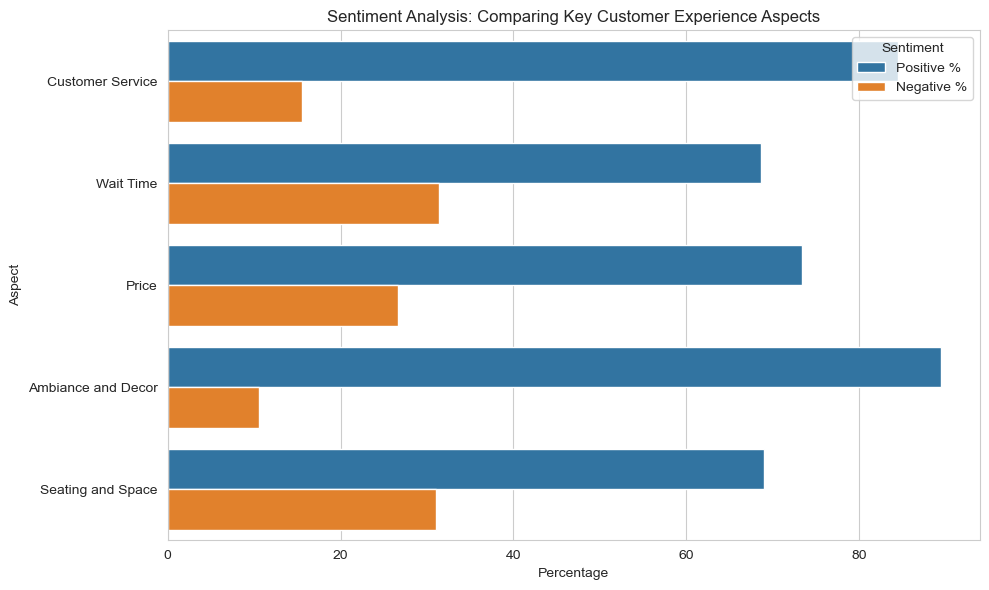

In [32]:
data = {
    'Aspect': ['Customer Service', 'Wait Time', 'Price', 'Ambiance and Decor', 'Seating and Space'],
    'Total Mentions': [58, 70, 30, 38, 58],
    'Positive': [49, 48, 22, 34, 40],
    'Negative': [9, 22, 8, 4, 18]
}

df = pd.DataFrame(data)

df['Positive %'] = df['Positive'] / df['Total Mentions'] * 100
df['Negative %'] = df['Negative'] / df['Total Mentions'] * 100

melted_df = df.melt(id_vars=['Aspect'], value_vars=['Positive %', 'Negative %'],
                    var_name='Sentiment', value_name='Percentage')
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Percentage', y='Aspect', hue='Sentiment', data=melted_df, ci=None)

plt.title('Sentiment Analysis: Comparing Key Customer Experience Aspects')
plt.xlabel('Percentage')
plt.ylabel('Aspect')
plt.legend(title='Sentiment', loc='upper right')

plt.tight_layout()
plt.show()